# Convolutionnal Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [2]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="int32")
white = np.array(white, dtype="int32")

clean_dataset = []
white_dataset = []

samples_length = nperseg

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)

In [3]:
stft_clean_dataset_real = []
stft_clean_dataset_imag = []
stft_white_dataset_real = []
stft_white_dataset_imag = []

for i in clean_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_clean_dataset_real.append(np.real(inp).T)
    stft_clean_dataset_imag.append(np.imag(inp).T)
    
for i in white_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_white_dataset_real.append(np.real(inp).T)
    stft_white_dataset_imag.append(np.imag(inp).T)

stft_clean_dataset_real = np.array(stft_clean_dataset_real)
stft_clean_dataset_imag = np.array(stft_clean_dataset_imag)
stft_white_dataset_real = np.array(stft_white_dataset_real)
stft_white_dataset_imag = np.array(stft_white_dataset_imag)
print(stft_clean_dataset_real.shape, stft_clean_dataset_imag.shape, stft_white_dataset_real.shape, stft_white_dataset_imag.shape)

(10659, 3, 513) (10659, 3, 513) (10659, 3, 513) (10659, 3, 513)


In [4]:
data_shape = stft_clean_dataset_real.shape[1:]

In [5]:
def view_output(stft_white_dataset_real, gan, p):
    outputs = []
    for i in range(10):
        y = np.reshape(stft_white_dataset_real[i, :, :], (-1, stft_white_dataset_real.shape[1], stft_white_dataset_real.shape[2]))
        t, y1 = istft(np.reshape(gan.g.predict(y).T, data_shape[::-1])+np.imag(stft_white_dataset_imag[i]).T)
        y2 = np.reshape(y1.T, (clean_dataset.shape[1],))
        outputs.append(y2)
    b = np.concatenate(outputs)
    c, t, bxx = stft(b, fs=samplerate, nperseg=nperseg)
    displaySpectrogram(bxx)
    plt.savefig(str(p)+".png", format='png')

# CGAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

A first model is saved in `'save2/gan_without_add'`. It does not have any add layer. It has been train on 3104 steps on 5000 samples of size 2048, visualizable in the folder `save2` gif.

A first model is saved in `'save2/gan_with_add'`. It does have an add layer. It has been train on 2475 steps on 10000 samples of size 1024, visualizable in the folder `save3` gif.

### Discriminator

The discriminator here uses a layer to process the Short-Time Fourier Transform (https://en.wikipedia.org/wiki/Short-time_Fourier_transform) before reducing the problem dimension to one single boolean prediction layer.

Interestingly, adding a Dropout layer on the input seems to prevent the generator to adapt itself to the little flaws of detection (which then only produces noise unrecognized by the discriminator).

In [6]:
def discriminator(input_shape):
    inputs = tf.keras.Input(shape=(input_shape[1], input_shape[2]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    #x3 = tf.keras.layers.Dense(512, activation="tanh")(x)
    x4 = tf.keras.layers.Dense(256, activation="tanh")(x)
    x5 = tf.keras.layers.Dense(128, activation="tanh")(x4)
    x6 = tf.keras.layers.Dense(1, activation="tanh")(x5)
    x7 = tf.keras.layers.Flatten()(x6)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x7)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer= 'adam', loss='bce', metrics=['accuracy'])
    return model

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both the size of the stft array.

In [7]:
def generator(sizes):
    inputs = tf.keras.Input(shape=(sizes[1], sizes[2]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    x1 = tf.keras.layers.Dense(10, activation='tanh')(x)
    x4 = tf.keras.layers.Dense(sizes[2], activation='tanh')(x1)
    x5 = tf.keras.layers.Add()([inputs, x4])
    outputs = tf.keras.layers.Dense(sizes[2], activation='linear')(x5)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [8]:
def evaluate_generator(g, inputs, outputs, size=100):
    res = 0
    s = min(size, inputs.shape[0])
    for i in range(s):
        error = (g.predict(np.reshape(inputs[i], (-1, inputs[i].shape[0], inputs[i].shape[1])))-outputs[i])**2
        res += np.sum(error)
    return res/(s*100000000)

## Building the GAN

In [9]:
def get_generator_outputs(white, train_size, g, nperseg, clean):
    steps = train_size//20
    rng = np.random.default_rng()
    g_outputs = []
    batch = rng.choice(white, train_size)
    for i in range(train_size):
        if i%steps == 0:
            print("=", end='')
        t = np.reshape(white[i, :, :], (-1, white.shape[1], white.shape[2]))
        m = g.predict(t)
        g_outputs.append(m)
    print()
    g_outputs = np.reshape(np.array(g_outputs), (train_size,  white.shape[1], white.shape[2]))
    input_data = np.concatenate((g_outputs, clean[:train_size,]))
    output_data = np.concatenate((np.zeros((train_size,)), np.ones((train_size,))))
    return input_data, output_data

In [10]:
class GAN:
    def __init__(self, size, g, d):
        self.g = g
        self.d = d
        self.size = size
        self.build()
        
    def build(self):
        self.z = self.g.inputs
        self.image = self.g(self.z)
        self.valid = self.d(self.image)
        self.combined_network = tf.keras.Model(self.z, self.valid)
        self.compile()
        
    def block_discriminator(self):
        self.d.trainable = False
        self.g.trainable = True
        self.build()
        
    def block_generator(self):
        self.g.trainable = False
        self.d.trainable = True
        self.build()
        
    def compile(self):
        self.combined_network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [17]:
g = generator(stft_white_dataset_real.shape)
d = discriminator(stft_white_dataset_real.shape)
gan = GAN(stft_white_dataset_real.shape, g, d)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3, 513)]     0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 3, 513)       0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 3, 10)        5140        dropout_2[0][0]                  
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 3, 513)       5643        dense_7[0][0]                    
________________________________________________________________________________________

In [18]:
def train_on_batch(d, i, o, validation_split=0, batch_size=16, verbose=True):  
    history = d.fit(i, o, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
    return np.mean(history.history['accuracy'])

In [19]:
train_size = 10000#stft_white_dataset_real.shape[0]

### Pretraining the discriminator

d_accuracy = 0
while d_accuracy < 0.5:
    d_accuracy = train_on_batch(gan.d, np.concatenate((stft_white_dataset_real[:train_size], stft_clean_dataset_real[:train_size])), np.concatenate((np.zeros(train_size), np.ones(train_size))), verbose=True)

In [20]:
p = 1
q = 1

Step 0
Training the discriminator
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1727 - accuracy: 0.9786
Training the generator
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6209 - accuracy: 0.2863
1.060109479021215
2500/2500 [==============================] - 6s 2ms/step - loss: 0.0557 - accuracy: 0.9345
1.3811104459241965
2500/2500 [==============================] - 6s 2ms/step - loss: 0.0365 - accuracy: 0.9630
1.7518710982277312
Step 1
Training the discriminator
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0830 - accuracy: 0.9757
Training the generator
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9259 - accuracy: 0.0317
2.7240046877234763
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2305 - accuracy: 0.6907
3.1978201170351164
2500/2500 [==============================] - 6s 2ms/step - loss: 0.0957 - accuracy: 0.8724
3.619551447119753
2500/2500 [==============================] - 6

2500/2500 [==============================] - 5s 2ms/step - loss: 0.9944 - accuracy: 8.0000e-04
33.15604679248949
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9903 - accuracy: 0.0022
33.65558811869742
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9869 - accuracy: 0.0035
34.04616747222585
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9827 - accuracy: 0.0042
34.45081182375728
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9775 - accuracy: 0.0074
34.961374643233206
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9687 - accuracy: 0.0117
35.50351121582237
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9527 - accuracy: 0.0189
36.23641978182287
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9339 - accuracy: 0.0303
36.788111856294094
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9058 - accuracy: 0.0508
37.24744564744435
Step 8
Traini

2500/2500 [==============================] - 5s 2ms/step - loss: 0.9845 - accuracy: 0.0065
60.1727172668246
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9812 - accuracy: 0.0095
60.65396632987219
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9775 - accuracy: 0.0118
61.328262086525235
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9742 - accuracy: 0.0128
61.83989988923141
Step 14
Training the discriminator
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0058 - accuracy: 0.9983
Training the generator
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9977 - accuracy: 4.8856e-04
62.48722635662138
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9972 - accuracy: 5.0000e-04
62.5917733691255
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9971 - accuracy: 8.0000e-04
63.11872931149432
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9960 - acc

2500/2500 [==============================] - 6s 2ms/step - loss: 0.9961 - accuracy: 0.0015
83.91894955970781
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9957 - accuracy: 0.0019
84.51789686003926
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9952 - accuracy: 0.0023
84.5838805733777
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9955 - accuracy: 0.0016
84.87452130204326
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9933 - accuracy: 0.0024
85.3798902929255
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9940 - accuracy: 0.0019
85.53695022003224
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9933 - accuracy: 0.0028
85.72088132477747
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9917 - accuracy: 0.0038
86.25833875338546
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9915 - accuracy: 0.0037
86.38080911825854
2500/2500 [==========

2500/2500 [==============================] - 6s 2ms/step - loss: 0.9970 - accuracy: 0.0017
104.03126755522602
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9964 - accuracy: 0.0014
104.24159196981682
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9962 - accuracy: 0.0019
104.2898596155044
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9962 - accuracy: 0.0013
104.43483695368951
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9959 - accuracy: 0.0018
104.7978332546327
Step 27
Training the discriminator
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0073 - accuracy: 0.9972
Training the generator
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9967 - accuracy: 8.8728e-04
105.01482087698862
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9957 - accuracy: 0.0017
105.65844340056846
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9952 - accur

2500/2500 [==============================] - 5s 2ms/step - loss: 0.9914 - accuracy: 0.0038
120.61063628986103
Step 33
Training the discriminator
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0030 - accuracy: 0.9992
Training the generator
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9990 - accuracy: 2.2764e-04
120.92640611270322
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9987 - accuracy: 4.0000e-04
121.85593758886995
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9991 - accuracy: 1.0000e-04
122.05488428131378
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9987 - accuracy: 4.0000e-04
122.13793208921201
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9987 - accuracy: 5.0000e-04
122.32157773960391
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9985 - accuracy: 6.0000e-04
123.05915189000076
2500/2500 [==============================] - 5s 2ms/step 

2500/2500 [==============================] - 6s 2ms/step - loss: 0.9933 - accuracy: 0.0034
138.24976802851086
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9925 - accuracy: 0.0036
138.74136115240006
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9932 - accuracy: 0.0035
138.79536187411782
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9933 - accuracy: 0.0027
139.16155865755135
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9928 - accuracy: 0.0036
139.39064866664137
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9913 - accuracy: 0.0039
139.70206495927647
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9909 - accuracy: 0.0045
140.02343714113343
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9885 - accuracy: 0.0063
140.2368909685967
Step 40
Training the discriminator
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0051 - accuracy: 0.

2500/2500 [==============================] - 6s 2ms/step - loss: 0.9977 - accuracy: 8.0000e-04
153.43830851680633
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9973 - accuracy: 0.0014
153.53772595671083
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9967 - accuracy: 0.0010
153.68730429375157
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9975 - accuracy: 0.0010
153.9429527923804
Step 46
Training the discriminator
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0040 - accuracy: 0.9987
Training the generator
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9942 - accuracy: 0.0028
154.23670447277166
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9935 - accuracy: 0.0032
154.79961876877798
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9917 - accuracy: 0.0035
154.8158657319733
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9930 - accur

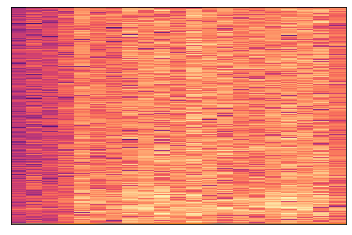

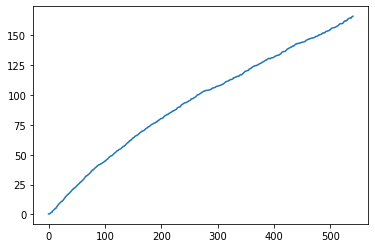

In [21]:
disc_acc = []
gen_loss = [0]
gan_acc = []
for e in range(50):
    g_accuracy = 0
    d_accuracy = 0
    print("Step", e)
    if d_accuracy < 1:
        i, o = get_generator_outputs(stft_white_dataset_real, train_size, gan.g, nperseg, stft_clean_dataset_real)
    gan.block_generator()
    print("Training the discriminator")
    s = 0
    err = evaluate_generator(gan.g, stft_white_dataset_real, stft_clean_dataset_real, 100)
    while d_accuracy < 0.95 and s<10:
        d_accuracy = train_on_batch(gan.d, i, o, verbose=True)
        disc_acc.append(d_accuracy)
        gan_acc.append(0)
        s+=1
        gen_loss.append(err)
    gan.block_discriminator()
    print("Training the generator")
    s = 0
    while g_accuracy < 0.95 and s<10:
        view_output(stft_white_dataset_real, gan,p)
        s+=1
        p+=1
        g_accuracy = train_on_batch(gan.combined_network, stft_white_dataset_real[:train_size], np.ones(train_size), batch_size=4, verbose=True)
        gan_acc.append(g_accuracy)
        disc_acc.append(0)
        err = evaluate_generator(gan.g, stft_white_dataset_real, stft_clean_dataset_real, 100)
        print(err)
        gen_loss.append(err)
    #print(evaluate_generator(gan.g, white_dataset, clean_dataset))
plt.plot(disc_acc)
plt.plot(gan_acc)
plt.show()
plt.plot(gen_loss[1:])
plt.show()

In [ ]:
#gan.combined_network.save('save2/gan_with_add')

In [ ]:
Audio(a, rate=samplerate)

In [ ]:
Audio(b, rate=samplerate)